This file contains functions to visualize and select the best training curves from our experiments.

In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('cmu_paper')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

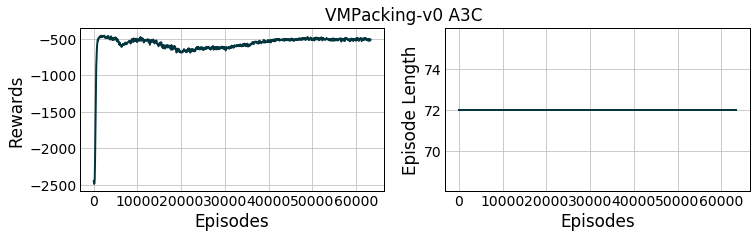

/home/christian/ray_results/A3C/A3C_VMPacking-v0_079ae2cc_0_entropy_coeff=0.001,lr=1e-05_2020-04-22_21-35-00_4c5yoe7


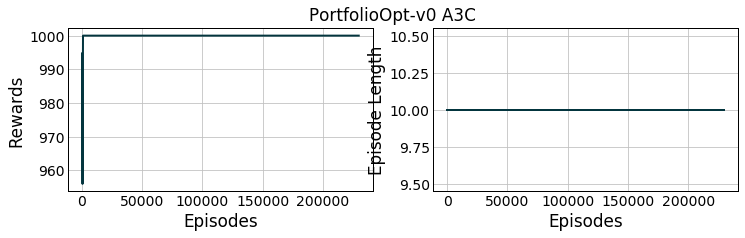

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d4_0_entropy_coeff=0.001,lr=0.0001_2020-05-04_20-53-40uc0pd4qx


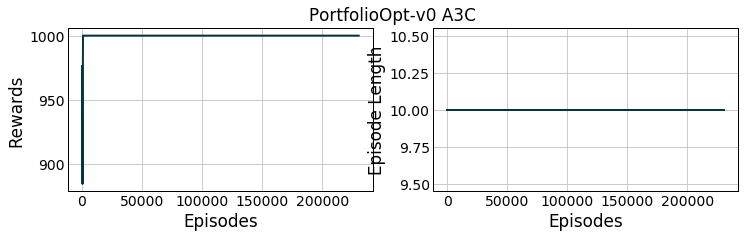

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d5_1_entropy_coeff=0.0001,lr=0.0001_2020-05-04_20-53-403t_mcs_6


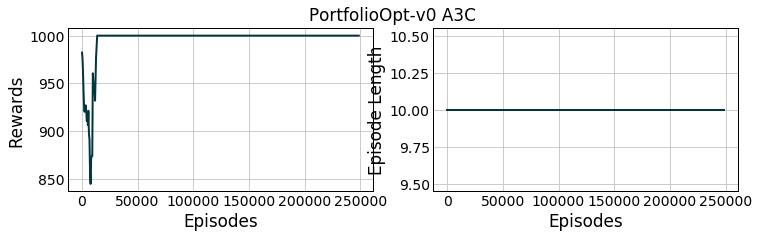

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d6_2_entropy_coeff=0.001,lr=1e-05_2020-05-04_20-53-4076r252vy


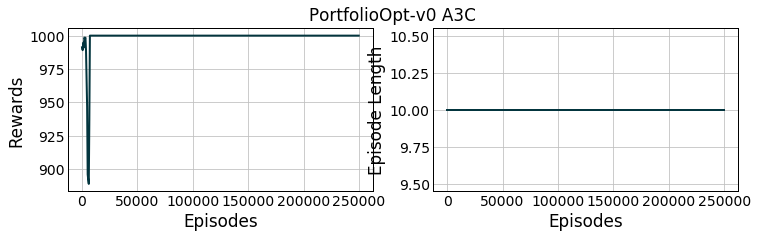

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d7_3_entropy_coeff=0.0001,lr=1e-05_2020-05-04_21-41-16o5qosc9b


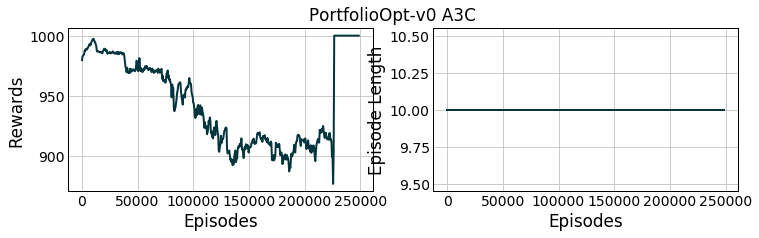

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d8_4_entropy_coeff=0.001,lr=1e-06_2020-05-04_21-41-16dd03ncu4


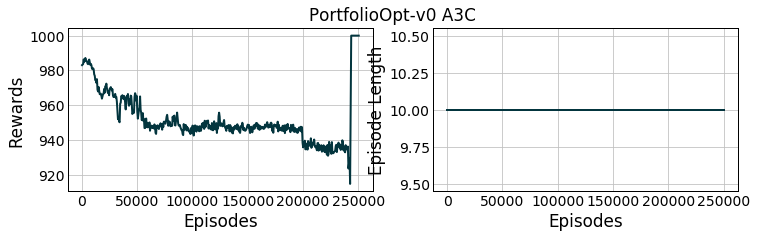

/home/christian/ray_results/A3C/A3C_PortfolioOpt-v0_3e2f98d9_5_entropy_coeff=0.0001,lr=1e-06_2020-05-04_22-27-46v2duojds


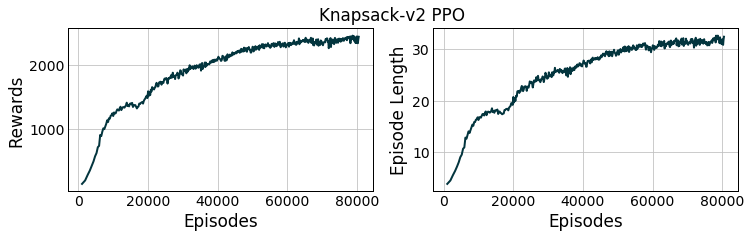

/home/christian/ray_results/PPO/PPO_Knapsack-v2_5_entropy_coeff=0.001,kl_target=0.01,lr=1e-05_2020-07-30_10-05-27rvljkqky


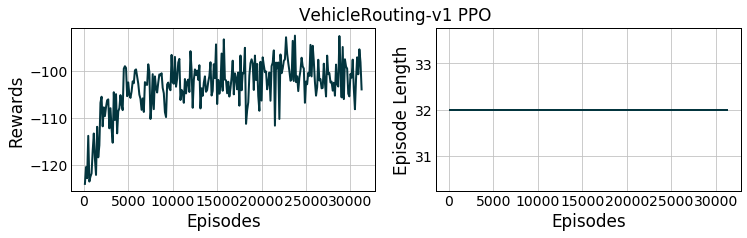

/home/christian/ray_results/PPO/PPO_VehicleRouting-v1_238b7de5_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-02_20-20-4547ljic2_


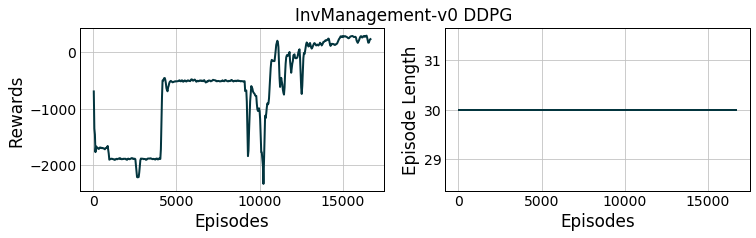

/home/christian/ray_results/DDPG/DDPG_InvManagement-v0_aa4f27f4_2_lr=1e-06_2020-05-09_00-19-32o2wiqc2d


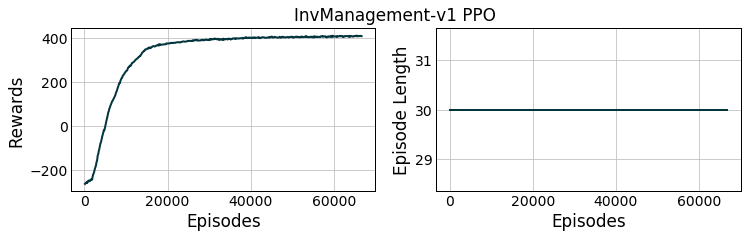

/home/christian/ray_results/PPO/PPO_InvManagement-v1_0_lr=0.0001_2020-05-20_19-27-518qt5htde


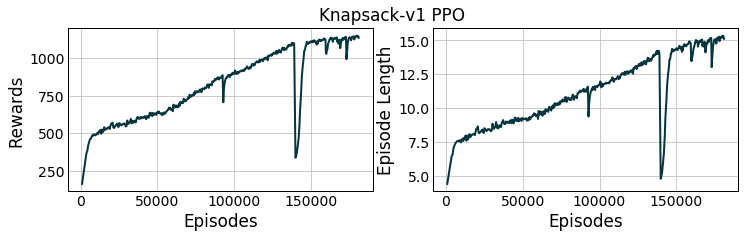

/home/christian/ray_results/PPO/PPO_Knapsack-v1_9_entropy_coeff=0.001,kl_target=0.01,lambda=0.95,lr=1e-05_2020-07-29_18-53-40iezku6bf


In [2]:
# Get data from results folders
result_path = '../or_gym/benchmarks/results'
results = os.listdir(result_path)
envs = set([i.split('_')[0] for i in results])
for env in envs:
    result_data = pd.DataFrame()
    for data_path in results:
        if env in data_path:
            _result_data = pd.read_csv(
                os.path.join(result_path, data_path))
            result_data = pd.concat([result_data, _result_data])
            
    top_results = result_data.loc[
        result_data['episode_reward_mean']==result_data['episode_reward_mean'].max()]
    
    for _path in top_results['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        train_data = pd.read_csv(_path + '/progress.csv')
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        ax[0].plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
#         ax[0].set_title(env + ' ' + algo_name)
        
        ax[1].plot(train_data['episodes_total'], train_data['episode_len_mean'])
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Episode Length')
        plt.suptitle(env + ' ' + algo_name)
#         plt.tight_layout()
        plt.show()
        print(_path)

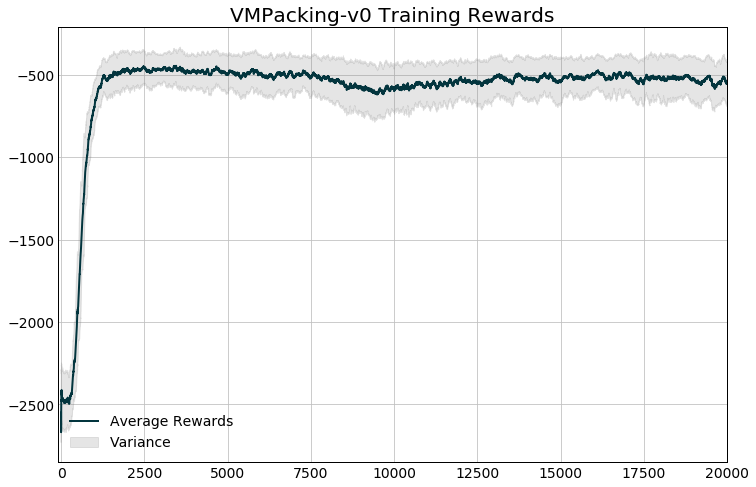

In [3]:
# Get episode totals
ep_stats = ['hist_stats/episode_reward']
train_data = pd.read_csv('/home/christian/ray_results/A3C/A3C_VMPacking-v0_079ae2cc_0_entropy_coeff=0.001,lr=1e-05_2020-04-22_21-35-00_4c5yoe7/progress.csv')
for i in ep_stats:
    vals = None
    ep_vals = train_data[i].values
    for j in ep_vals:
        ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
        if vals is None:
            vals = ep_vals.copy()
        else:
            vals = np.hstack([vals, ep_vals.copy()])

window = 100
reward_var = np.array([np.std(vals[i-window:i+1]) 
                       if i>window else np.std(vals[:i+1]) 
                       for i, j in enumerate(vals)])
med_reward = np.array([np.median(vals[i-window:i+1]) 
                       if i>window else np.median(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_max = np.array([np.max(vals[i-window:i+1]) 
                       if i>window else np.max(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_min = np.array([np.min(vals[i-window:i+1]) 
                       if i>window else np.min(vals[:i+1]) 
                       for i, j in enumerate(vals)])
mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                       if i>window else np.mean(vals[:i+1]) 
                       for i, j in enumerate(vals)])
if np.max(mean_vals) > 0:
    fill_max = np.where(mean_vals + reward_var<=ep_max, mean_vals+reward_var, ep_max)
    fill_min = np.where(mean_vals - reward_var>0, mean_vals-reward_var, 0)
else:
    fill_max = np.where(mean_vals + reward_var<=0, mean_vals+reward_var, ep_max)
    fill_min = np.where(mean_vals - reward_var>ep_min, mean_vals-reward_var, ep_min)

plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
# plt.plot(med_reward, label='Median Rewards')
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='Variance')
plt.title('VMPacking-v0 Training Rewards')
plt.legend()
plt.xlim([-100, 20000])
plt.show()

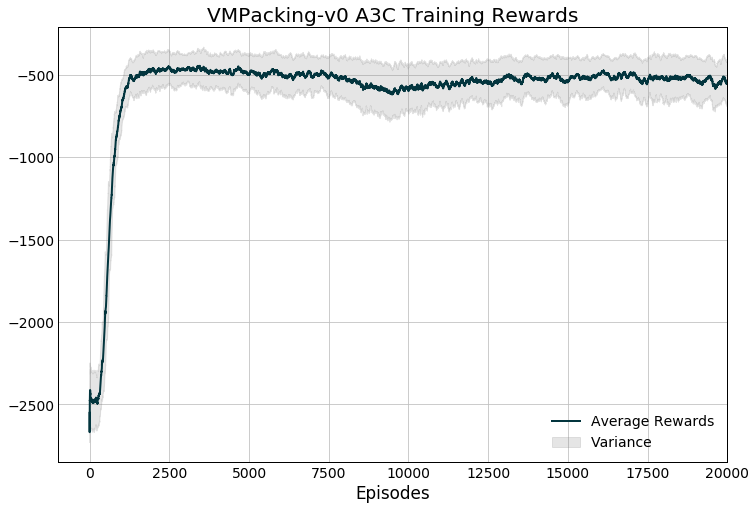

In [40]:
plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
# plt.plot(med_reward, label='Median Rewards')
# plt.fill_between(np.arange(mean_vals.shape[0]), -3000, 0, color='gray', alpha=0.2)
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='Variance')

plt.title('VMPacking-v0 A3C Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([-1000, 20000])
plt.show()

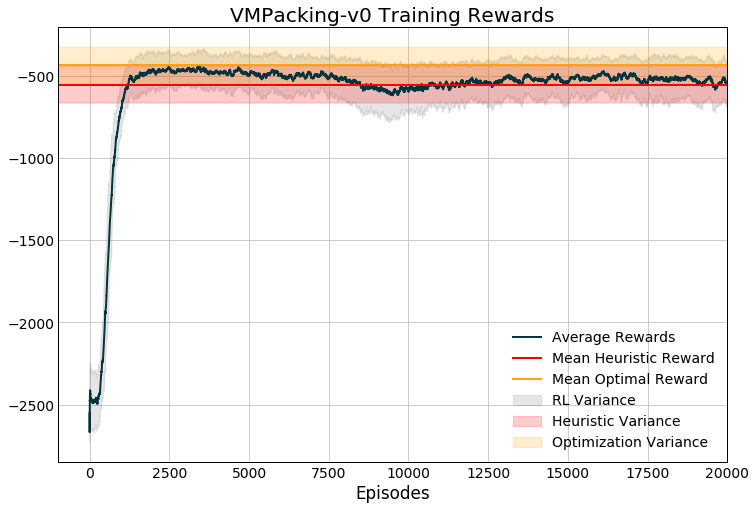

In [6]:
x_min = -1000
x_max = 20000
opt_mean = -438.8
opt_var = 111
heur_mean = -556.2
heur_var = 111.2

plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='RL Variance')

plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Heuristic Reward')
plt.fill_between(np.arange(x_min, mean_vals.shape[0]), heur_mean-heur_var, 
                 heur_mean+heur_var, color='r', alpha=0.2, label='Heuristic Variance')

plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean Optimal Reward')
plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
                 opt_mean+opt_var, color='orange', alpha=0.2, label='Optimization Variance')

plt.title('VMPacking-v0 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

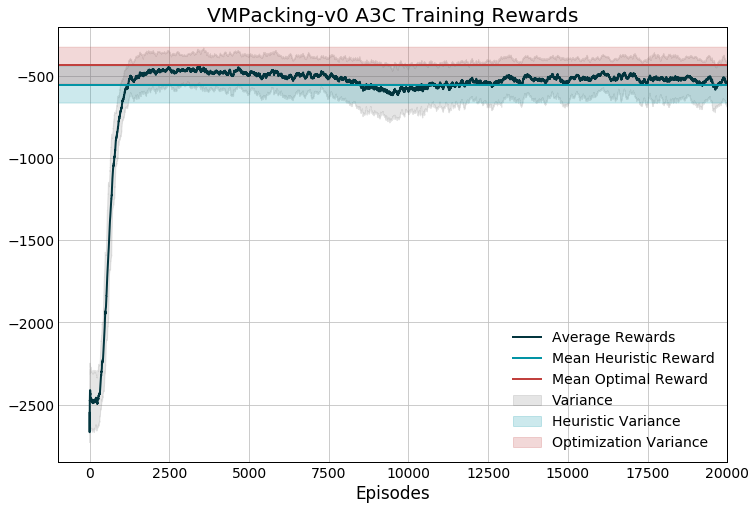

In [42]:
x_min = -1000
x_max = 20000
opt_mean = -438.8
opt_var = 111
heur_mean = -556.2
heur_var = 111.2

plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='Variance')

plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color=colors[1], label='Mean Heuristic Reward')
plt.fill_between(np.arange(x_min, mean_vals.shape[0]), heur_mean-heur_var, 
                 heur_mean+heur_var, color=colors[1], alpha=0.2, label='Heuristic Variance')

plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color=colors[2], label='Mean Optimal Reward')
plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
                 opt_mean+opt_var, color=colors[2], alpha=0.2, label='Optimization Variance')

plt.title('VMPacking-v0 A3C Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

In [23]:
vals[-100:].std()

111.00743404089985

In [41]:
data = pd.read_csv('../or_gym/benchmarks/results/VMPacking-v0_or_gym_tune_2020-04-13.csv')
data

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,info/learner/default_policy/entropy_coeff,config/entropy_coeff,config/env,config/env_config,config/lr,config/model,config/num_workers,config/vf_clip_param,config/vf_share_layers,logdir
0,-1003.493313,-1250.342241,-1097.462244,24.558282,163,4000,True,1000000,56812,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
1,-1004.183975,-1228.260401,-1110.124231,27.376712,146,4000,True,1000000,56183,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
2,-1004.846325,-1192.904492,-1070.930941,18.741784,213,4000,True,1000000,78604,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
3,-1002.134130,-1152.306792,-1067.583072,19.588235,204,4000,True,1000000,77533,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
4,-1000.920722,-1555.138960,-1148.324953,14.921933,269,4000,True,1000000,44089,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
5,-1006.995235,-1641.756196,-1179.577573,16.196787,249,4000,True,1000000,42714,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...


In [5]:
result_data.tail()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,config/num_workers,logdir,info/exploration_infos,info/num_target_updates,info/sample_time_ms,info/replay_time_ms,info/grad_time_ms,info/update_time_ms,info/opt_peak_throughput,info/opt_samples
1,-535.949510,-662.403555,-589.256051,30.0,200,6000,True,3310000,110335,500,...,2,/home/christian/ray_results/A3C/A3C_InvManagem...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-542.201664,-640.503869,-588.223525,30.0,132,4000,True,2112000,70402,500,...,2,/home/christian/ray_results/A3C/A3C_InvManagem...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-2843.243906,-3195.986448,-3071.486070,30.0,34,1000,True,500000,16666,500,...,2,/home/christian/ray_results/DDPG/DDPG_InvManag...,"[1.0, 1.0, 1.0]",250000.0,5.130,9.356,21.821,27.323,11731.934,256.0
1,-1241.512580,-1813.675510,-1707.556791,30.0,34,1000,True,500000,16666,500,...,2,/home/christian/ray_results/DDPG/DDPG_InvManag...,"[1.0, 1.0, 1.0]",250000.0,7.805,12.481,28.022,5.516,9135.709,256.0
2,373.650970,29.822941,233.549964,30.0,34,1000,True,500000,16666,500,...,2,/home/christian/ray_results/DDPG/DDPG_InvManag...,"[1.0, 1.0, 1.0]",250000.0,5.630,9.745,21.193,4.139,12079.485,256.0


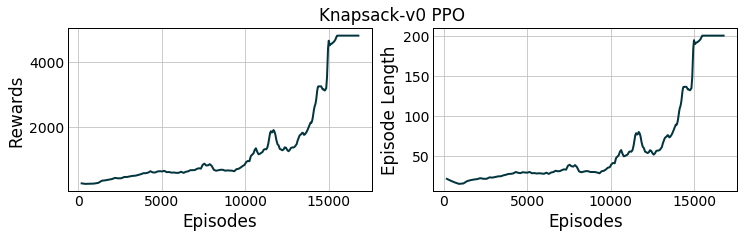

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da3_1_lr=0.001,vf_share_layers=True_2020-03-21_16-39-26_z6_97l8


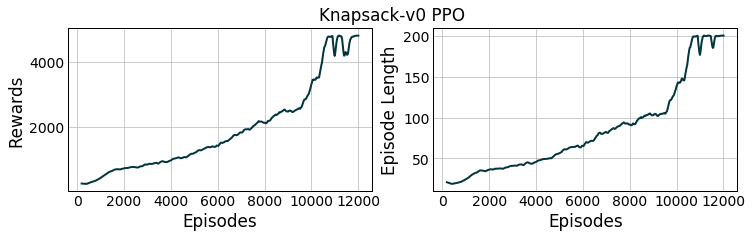

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da4_2_lr=0.0001,vf_share_layers=True_2020-03-21_17-13-03j4saa4bw


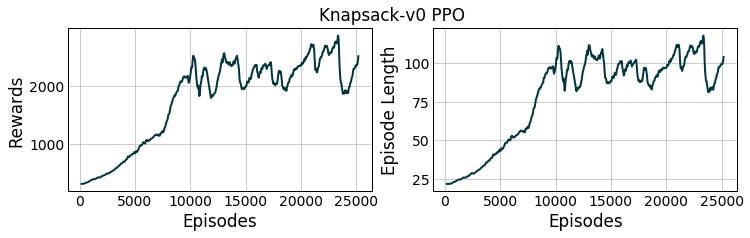

/home/christian/ray_results/PPO/PPO_Knapsack-v0_0_entropy_coeff=0.01,lr=0.0001_2020-05-26_21-52-04odor_3iw


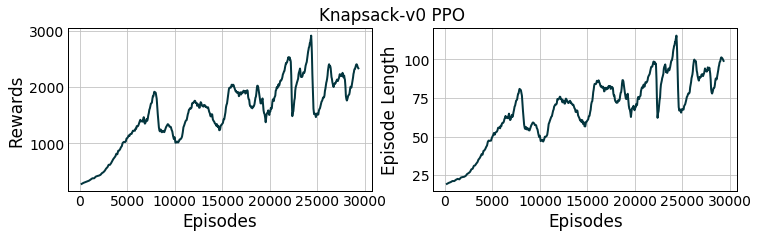

/home/christian/ray_results/PPO/PPO_Knapsack-v0_1_entropy_coeff=0.01,lr=1e-05_2020-05-26_21-52-059e_bv6r1


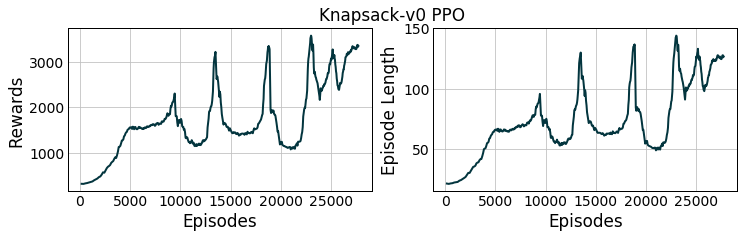

/home/christian/ray_results/PPO/PPO_Knapsack-v0_2_entropy_coeff=0.01,lr=1e-06_2020-05-26_21-52-05ghe739ui


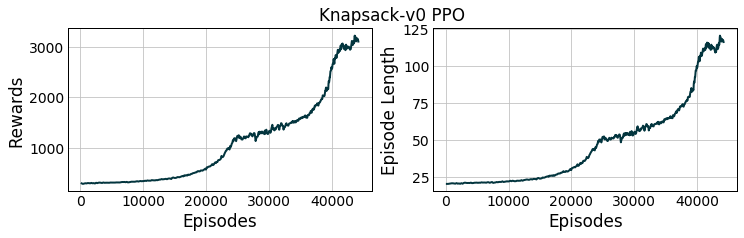

/home/christian/ray_results/PPO/PPO_Knapsack-v0_3_entropy_coeff=0.01,lr=1e-07_2020-05-26_23-15-52_pqbuu21


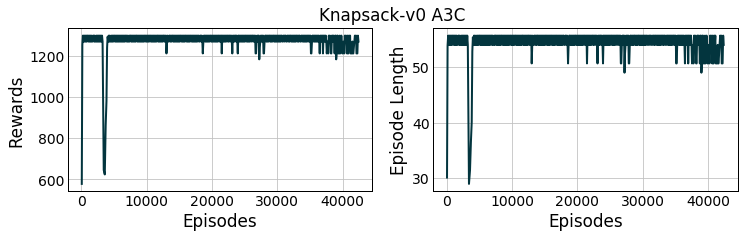

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e4e_0_entropy_coeff=0.001,lr=0.0001_2020-05-05_10-27-10l_951op6


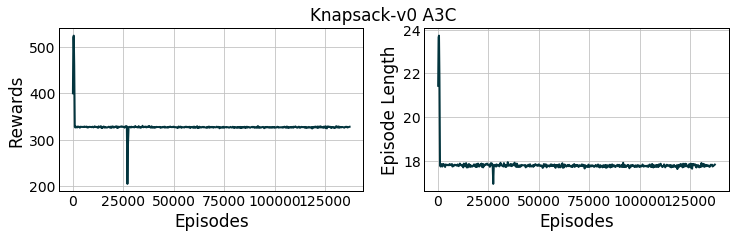

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e4f_1_entropy_coeff=0.0001,lr=0.0001_2020-05-05_10-27-10gtat0rau


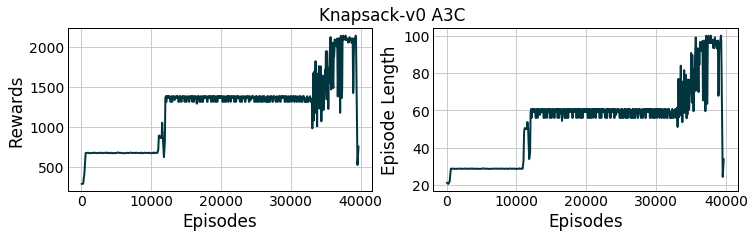

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e50_2_entropy_coeff=0.001,lr=1e-05_2020-05-05_10-27-10etc3aoru


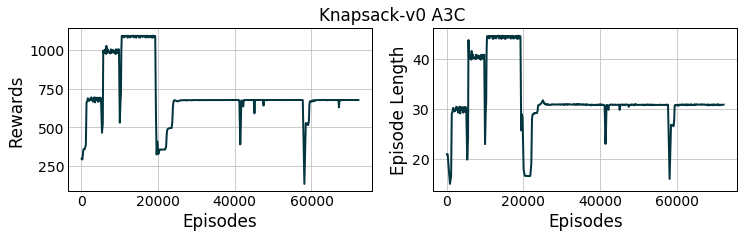

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e51_3_entropy_coeff=0.0001,lr=1e-05_2020-05-05_11-16-08yosh3vfx


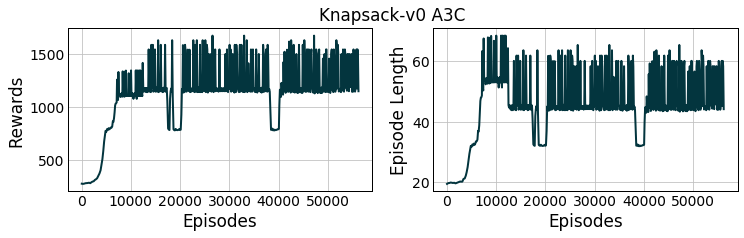

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e52_4_entropy_coeff=0.001,lr=1e-06_2020-05-05_11-16-096pwwton2


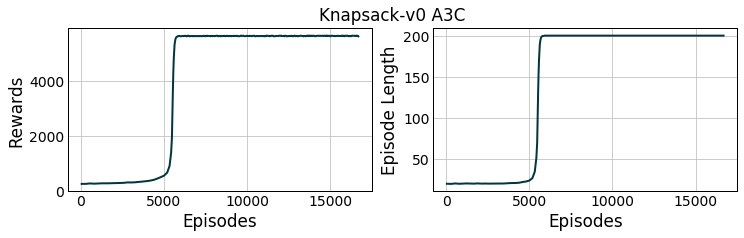

/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e53_5_entropy_coeff=0.0001,lr=1e-06_2020-05-05_12-04-157l2q7opu


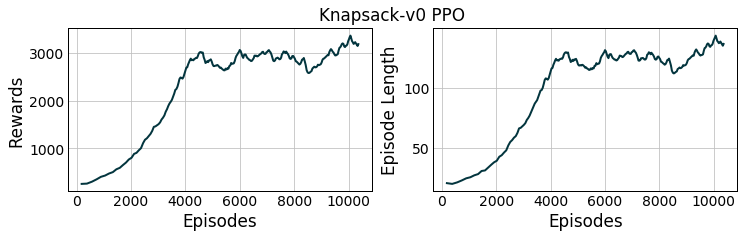

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd250_0_entropy_coeff=0.01,lr=0.0001,vf_share_layers=False_2020-04-15_07-07-53iozz_y5f


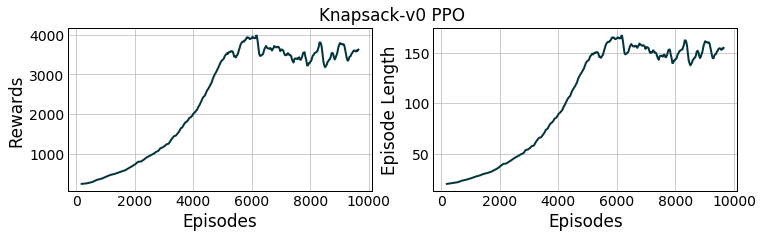

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd251_1_entropy_coeff=0.001,lr=0.0001,vf_share_layers=False_2020-04-15_07-07-53gcflga1c


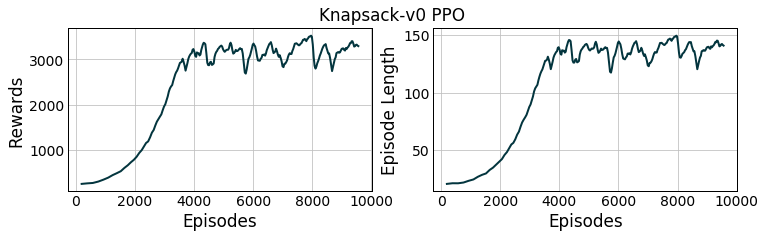

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd252_2_entropy_coeff=0.01,lr=1e-05,vf_share_layers=False_2020-04-15_07-47-30tmt7qysr


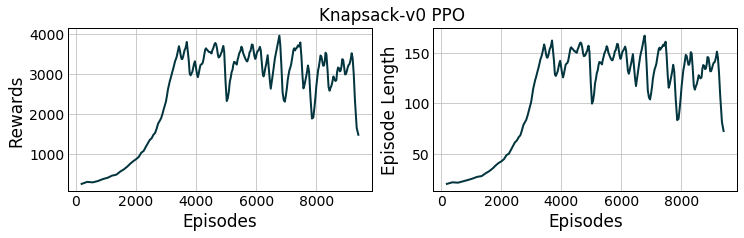

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd253_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-15_07-47-37pi4mzk1o


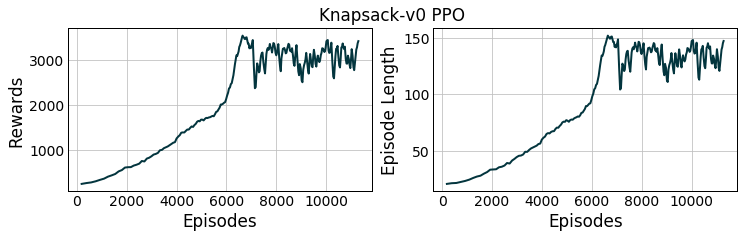

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd254_4_entropy_coeff=0.01,lr=1e-06,vf_share_layers=False_2020-04-15_08-24-370uryyibg


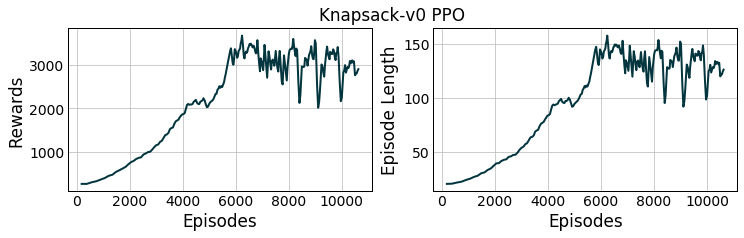

/home/christian/ray_results/PPO/PPO_Knapsack-v0_bbccd255_5_entropy_coeff=0.001,lr=1e-06,vf_share_layers=False_2020-04-15_08-24-42wa2wxiif


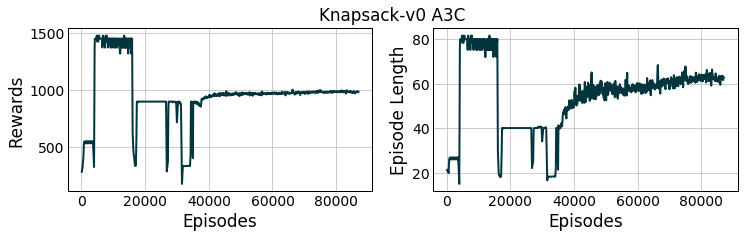

/home/christian/ray_results/A3C/A3C_Knapsack-v0_3de66006_0_entropy_coeff=0.001,lr=1e-05_2020-05-01_23-06-04k2sb8em6


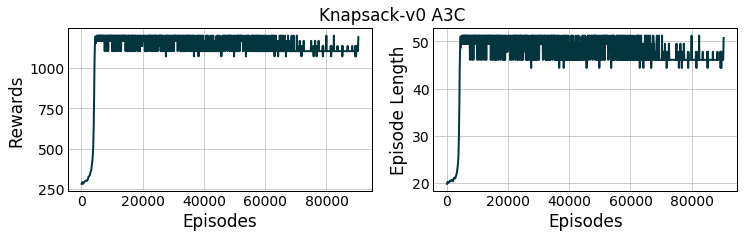

/home/christian/ray_results/A3C/A3C_Knapsack-v0_3de66007_1_entropy_coeff=0.001,lr=1e-06_2020-05-01_23-06-04rbj3xf9f


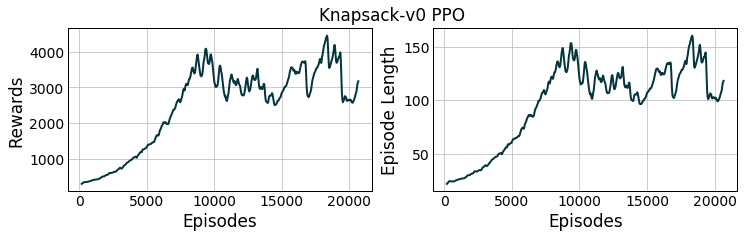

/home/christian/ray_results/PPO/PPO_Knapsack-v0_0_entropy_coeff=0.001,lr=0.0001_2020-05-27_17-21-47cn5zkzf4


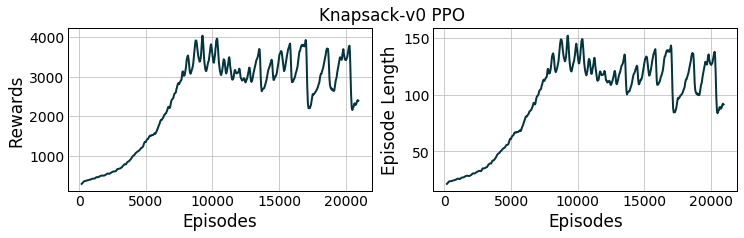

/home/christian/ray_results/PPO/PPO_Knapsack-v0_1_entropy_coeff=0.0001,lr=0.0001_2020-05-27_17-21-47f357rlng


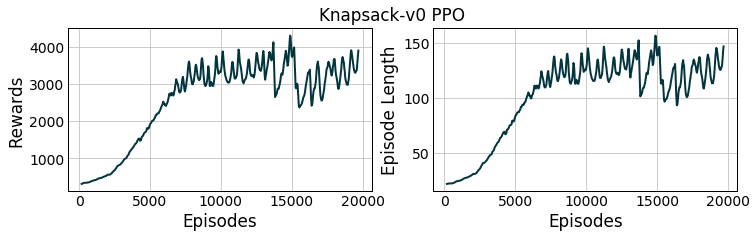

/home/christian/ray_results/PPO/PPO_Knapsack-v0_2_entropy_coeff=0.001,lr=1e-05_2020-05-27_17-21-47g7dkt8kl


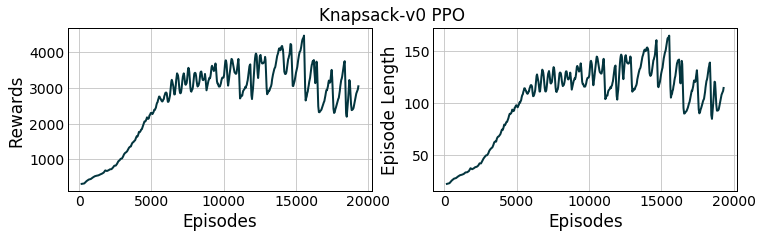

/home/christian/ray_results/PPO/PPO_Knapsack-v0_3_entropy_coeff=0.0001,lr=1e-05_2020-05-27_18-43-53tqexpc58


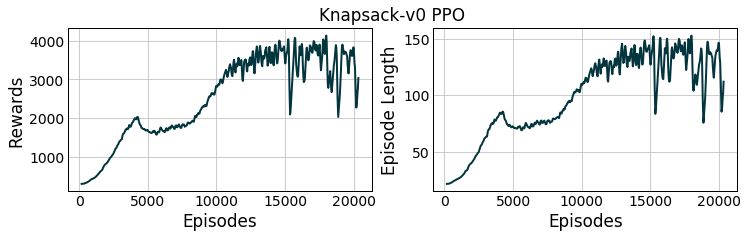

/home/christian/ray_results/PPO/PPO_Knapsack-v0_4_entropy_coeff=0.001,lr=1e-06_2020-05-27_18-43-54hs83u015


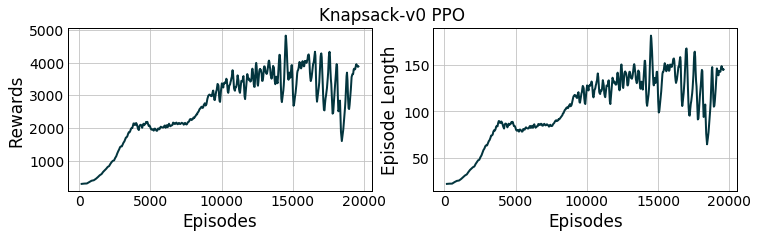

/home/christian/ray_results/PPO/PPO_Knapsack-v0_5_entropy_coeff=0.0001,lr=1e-06_2020-05-27_19-59-443t6x019k


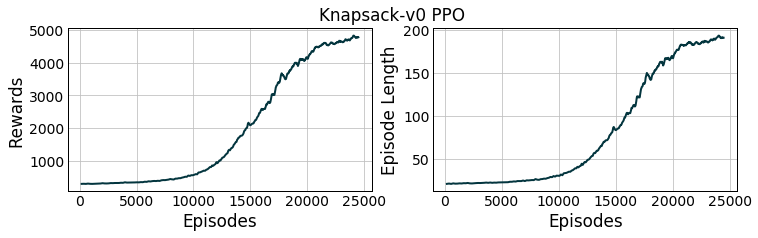

/home/christian/ray_results/PPO/PPO_Knapsack-v0_6_entropy_coeff=0.001,lr=1e-07_2020-05-27_19-59-44zbcv8ye1


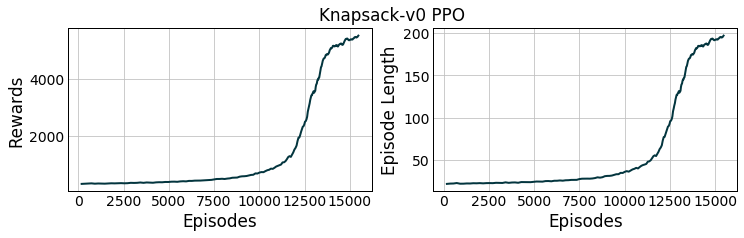

/home/christian/ray_results/PPO/PPO_Knapsack-v0_7_entropy_coeff=0.0001,lr=1e-07_2020-05-27_21-24-10bf7wxtw6


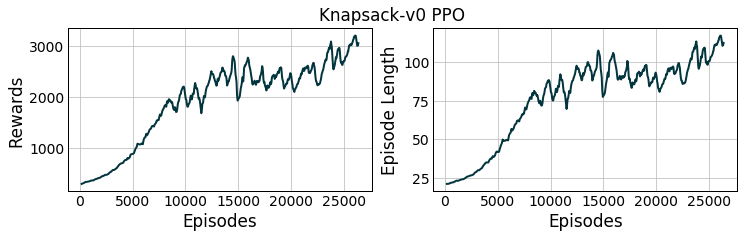

/home/christian/ray_results/PPO/PPO_Knapsack-v0_0_entropy_coeff=0.01,lr=0.0001_2020-05-24_20-52-3050htjp9q


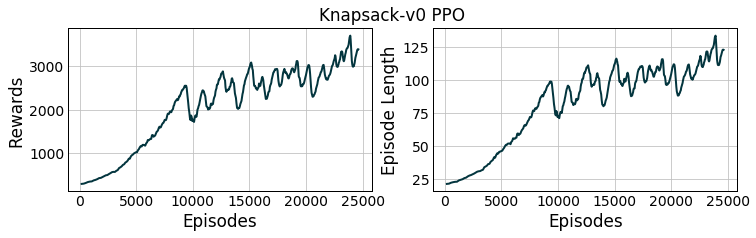

/home/christian/ray_results/PPO/PPO_Knapsack-v0_1_entropy_coeff=0.001,lr=0.0001_2020-05-24_20-52-30lt23c72d


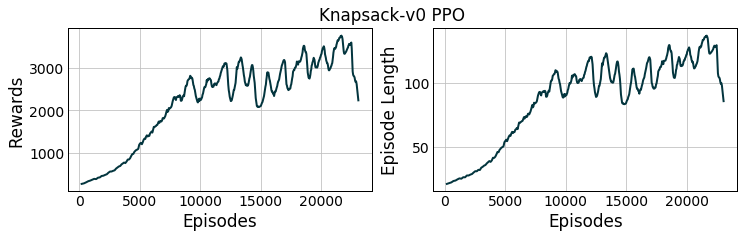

/home/christian/ray_results/PPO/PPO_Knapsack-v0_2_entropy_coeff=0.0001,lr=0.0001_2020-05-24_20-52-30e0lh9ma1


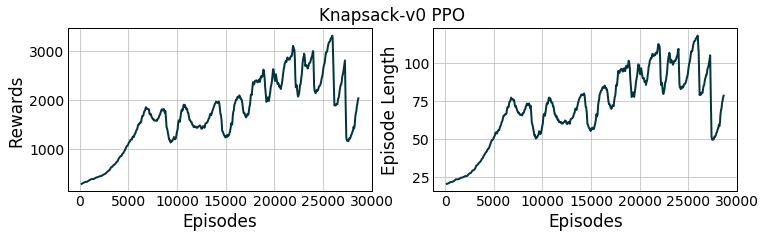

/home/christian/ray_results/PPO/PPO_Knapsack-v0_3_entropy_coeff=0.01,lr=1e-05_2020-05-24_22-03-19ilo228o7


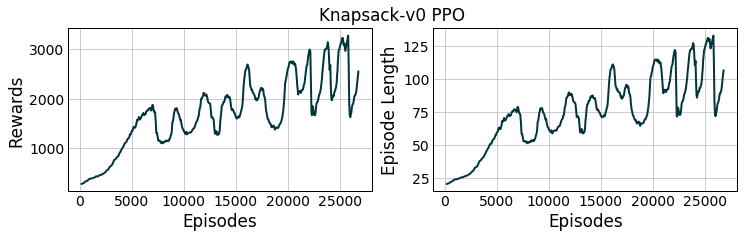

/home/christian/ray_results/PPO/PPO_Knapsack-v0_4_entropy_coeff=0.001,lr=1e-05_2020-05-24_22-03-191jj4at1a


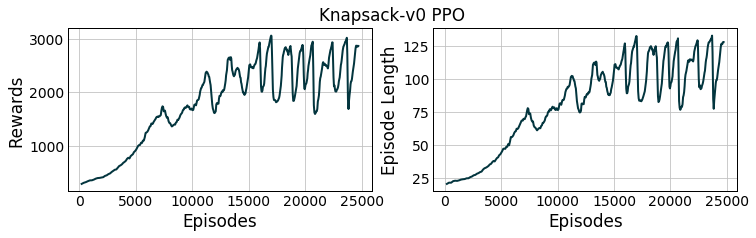

/home/christian/ray_results/PPO/PPO_Knapsack-v0_5_entropy_coeff=0.0001,lr=1e-05_2020-05-24_23-16-30jr69c2kw


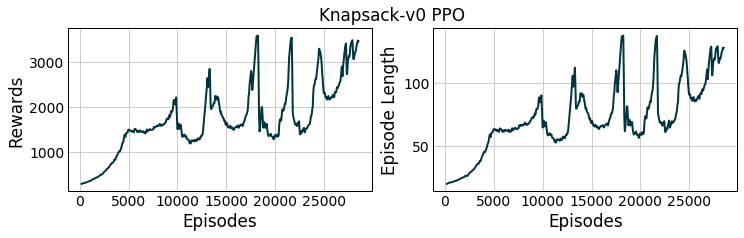

/home/christian/ray_results/PPO/PPO_Knapsack-v0_6_entropy_coeff=0.01,lr=1e-06_2020-05-24_23-16-30hpvqe4dt


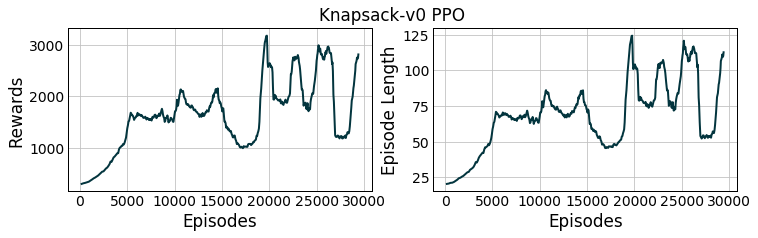

/home/christian/ray_results/PPO/PPO_Knapsack-v0_7_entropy_coeff=0.001,lr=1e-06_2020-05-25_00-29-13ds0xxnyp


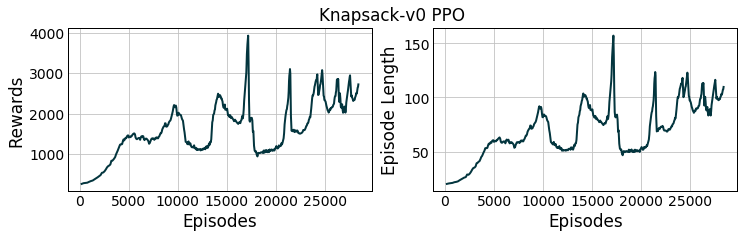

/home/christian/ray_results/PPO/PPO_Knapsack-v0_8_entropy_coeff=0.0001,lr=1e-06_2020-05-25_00-29-13ycfkdx4q


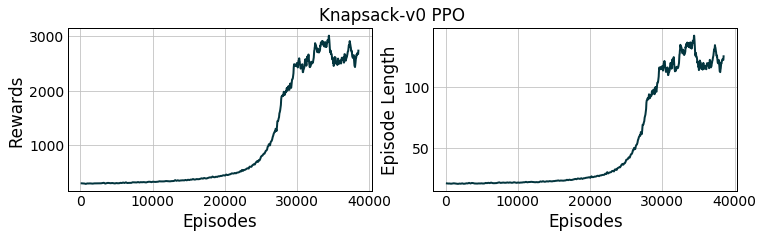

/home/christian/ray_results/PPO/PPO_Knapsack-v0_9_entropy_coeff=0.01,lr=1e-07_2020-05-25_01-42-442hkz8c2s


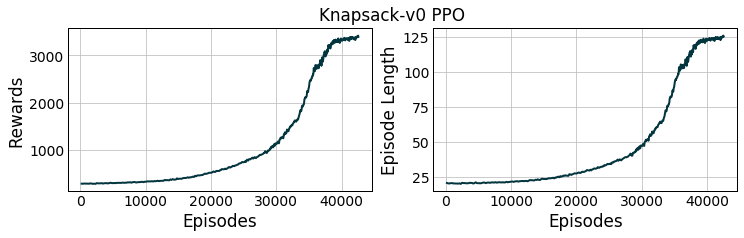

/home/christian/ray_results/PPO/PPO_Knapsack-v0_10_entropy_coeff=0.001,lr=1e-07_2020-05-25_01-42-44gk9cjw_a


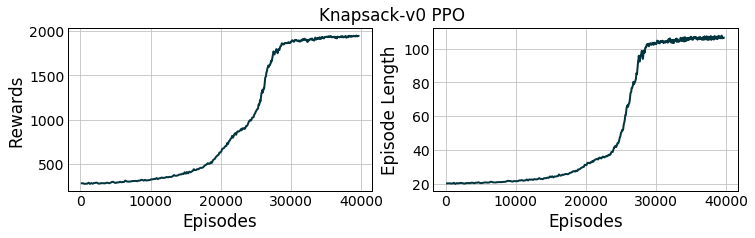

/home/christian/ray_results/PPO/PPO_Knapsack-v0_11_entropy_coeff=0.0001,lr=1e-07_2020-05-25_02-56-05q50xchd7


In [4]:
result_path = '../or_gym/benchmarks/results'
results = os.listdir(result_path)
envs = set([i.split('_')[0] for i in results])
envs = ['Knapsack-v0']
for env in envs:
    result_data = pd.DataFrame()
    for data_path in results:
        if env in data_path:
            _result_data = pd.read_csv(
                os.path.join(result_path, data_path))
            result_data = pd.concat([result_data, _result_data])
            
    for _path in result_data['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        try:
            train_data = pd.read_csv(_path + '/progress.csv')
        except FileNotFoundError:
            continue
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        ax[0].plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
#         ax[0].set_title(env + ' ' + algo_name)
        
        ax[1].plot(train_data['episodes_total'], train_data['episode_len_mean'])
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Episode Length')
        plt.suptitle(env + ' ' + algo_name)
#         plt.tight_layout()
        plt.show()
        print(_path)

In [7]:
path = '/home/christian/ray_results/PPO/PPO_InvManagement-v0_3_entropy_coeff=0.01,lr=1e-05_2020-05-19_20-59-32_o_4ganr'
data = pd.read_csv(path + '/progress.csv')

In [13]:
200*9.25

1850.0

In [9]:
7250 - 1840

5410

In [14]:
1850/6.5

284.61538461538464